# Part III - Dogs VS Cats 

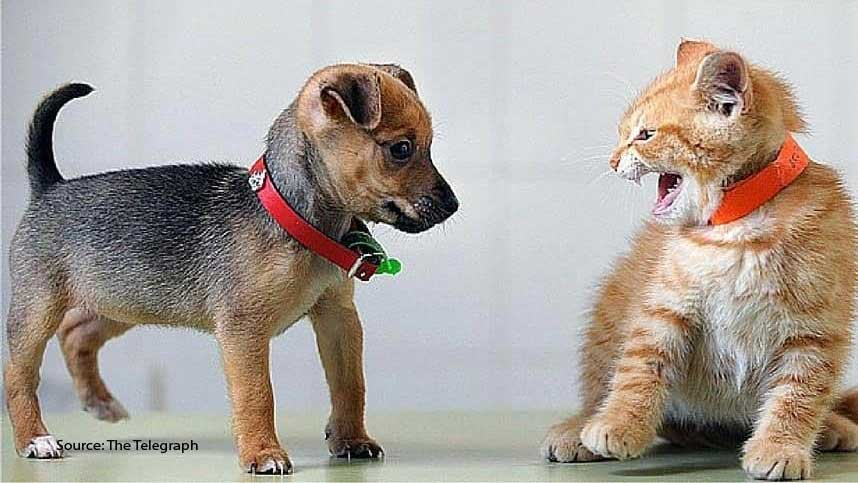

In [65]:
import cv2 # openCv
from os import listdir
from os.path import isfile, join
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator 
from keras import backend
import cv2 
from keras import applications

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

##### Link to kaggle: https://www.kaggle.com/c/dogs-vs-cats

We would like to create an array which will contain our images:

In [66]:
main = "C:\Haim\Anaconda\Dogs_VS_Cats"
train = "train"
train = os.path.join(main,train)

test = "test1"
test = os.path.join(main,test)


IMAGE_FOLDER_PATH="C:\Haim\Anaconda\Dogs_VS_Cats/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

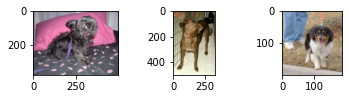

In [70]:
# create a grid of 3x3 images
for i in range(3):
    plt.subplot(331+i)
    filename=train+'/dog.'+str(i)+'.jpg'
    image=imread(filename)
    plt.imshow(image)
plt.show()  

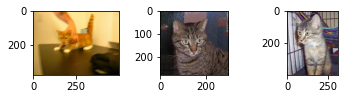

In [69]:
from matplotlib.image import imread
# create a grid of 3x3 images
for i in range(3):
    plt.subplot(331+i)
    filename = train+'/cat.'+str(i)+'.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()   

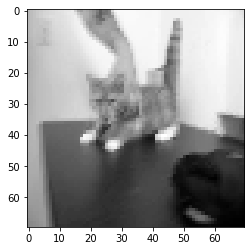

In [67]:
# random choose a single image from train dataset
for p in os.listdir(train):
    category = p.split(".")[0]
    image_read = cv2.imread(os.path.join(train,p),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(image_read,dsize=(70,70))
    plt.imshow(img,cmap="gray")
    break

We would like to make a pandas dataframe so we will be able to work with the data of each picture of our train folder

In [150]:
# create dataset
targets=list() # vector of the correct labels (dog or cat), our Y
data = np.ndarray((25000,4096), dtype=np.uint8) # 25000 images , 64^2*64^2 = 4096 pixels, our X size
for i, file_name in enumerate(FILE_NAMES): # each file name in our train folder 
    target = file_name.split(".")[0] # the name of each picture starts with dog or cat
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name) # folder path + the name of the picture
    img = cv2.imread(full_path) # read the photo into matrix of pixels (3D)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert the color into gray scale (2D matrix)
    resized_img = cv2.resize(gray_img, (64,64)) # resize each picture into 64*64 pixels
    targets.append(target) # add the correct label of the picture (dog/cat)
    data[i, :] = resized_img.flatten() # add the matrix as a row vector into the correct row in our data array

In [152]:
# we will convert out data array into pandas dataframe, each row present a picture, each column presents a spesific pixel
data = pd.DataFrame(data, columns= ["pixel"+ str(i+1)for i in range(data.shape[1])])
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
0,148,154,161,166,170,174,177,179,182,185,...,8,8,3,2,2,1,1,1,1,1
1,43,44,37,30,43,45,74,39,38,39,...,73,61,34,35,52,54,49,68,64,25
2,47,49,49,59,59,54,62,53,55,49,...,79,82,87,137,160,143,119,119,136,127
3,220,221,231,227,235,225,224,226,228,225,...,248,240,234,228,211,204,204,220,213,212
4,102,110,73,78,125,136,120,180,199,218,...,91,89,97,87,84,81,91,98,86,80


In [200]:
# we will convert out targets list into a pandas df so we will add it to the data df
labels = pd.DataFrame({"label":targets})
labels.sample(n = 4, random_state = 4).sort_values(by = 'label')

,label
1986,cat
944,cat
20921,dog
13294,dog


In [201]:
df = pd.concat([labels, data], axis=1)
df.sample(n = 4, random_state = 4).sort_values(by = 'label')

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
1986,cat,30,37,150,156,166,152,144,127,145,...,131,127,124,121,119,118,118,119,117,115
944,cat,122,128,134,145,153,160,164,169,177,...,68,70,71,65,60,58,58,54,54,54
20921,dog,120,110,201,120,92,73,149,89,154,...,116,118,122,122,102,99,89,101,92,82
13294,dog,134,135,66,54,112,89,105,112,140,...,143,156,62,181,112,134,157,141,123,131


In [202]:
df.shape

(25000, 4097)

After we created our dataset, lets take a look at the pictures now

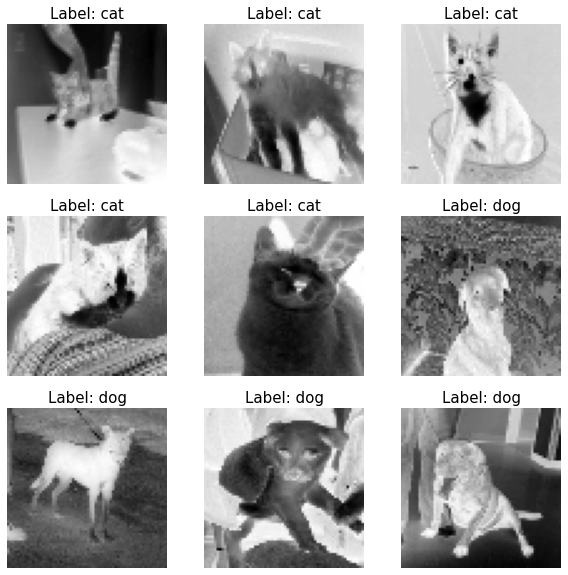

In [203]:
fig, axes = plt.subplots(3, 3, figsize = (10,10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(data.values.reshape((data.shape[0], 64, 64))[i*2550], cmap=plt.get_cmap('binary'))
    axes[i].set_title("Label: " + df.label[i*2550], size=15)
    axes[i].axis('off')
plt.show()

In [204]:
mapping = {'cat':0, 'dog':1}
df.label = df.label.map(mapping)
df.sample(2, random_state=555)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
614,0,65,61,62,62,62,62,58,58,58,...,149,136,129,146,139,127,122,111,109,99
13787,1,81,82,83,82,85,81,87,156,132,...,225,225,225,220,216,218,216,218,221,215


In [206]:
# A function to show the labels when we want it
def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Cat',
    1 :'Dog'}
    labeled = label.map(mapping)
    return labeled

In [209]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
count,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,0.50000,111.714560,112.230360,112.782240,113.306920,113.797720,114.525000,114.481520,115.282640,115.807320,...,123.117200,122.844680,122.353680,121.912120,121.265720,120.656280,119.850080,119.157440,118.150080,117.62132
std,0.50001,69.859821,69.543411,69.503277,69.291241,69.295868,69.484809,69.271914,69.391835,69.421611,...,65.820728,65.772271,65.713308,65.839489,65.803856,65.797229,66.061497,66.293231,66.358279,66.53869
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.00000,54.000000,54.000000,55.000000,55.000000,56.000000,57.000000,57.000000,58.000000,58.000000,...,71.000000,71.000000,71.000000,70.000000,69.000000,69.000000,68.000000,66.000000,65.000000,65.00000
50%,0.50000,105.000000,105.000000,106.000000,107.000000,108.000000,109.000000,108.000000,110.000000,110.000000,...,121.000000,120.000000,119.000000,119.000000,118.000000,118.000000,117.000000,116.000000,115.000000,113.00000
75%,1.00000,162.000000,163.000000,163.000000,164.000000,164.000000,166.000000,166.000000,167.000000,167.000000,...,171.000000,171.000000,171.000000,170.000000,169.000000,168.000000,168.000000,167.000000,166.000000,165.00000
max,1.00000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000


In [211]:
df[df['label']==0].describe() # for cats

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
count,12500.0,12500.000000,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000,12500.000000,12500.000000,12500.000000,...,12500.00000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000
mean,0.0,108.054480,108.727200,109.474800,110.274960,110.51360,111.341840,111.566720,112.599120,113.309760,...,123.98944,123.341680,122.742720,122.214000,121.433920,120.390560,119.157920,118.072000,116.827760,116.131760
std,0.0,70.343749,70.199144,70.095664,70.008282,70.15136,70.107786,69.955599,70.118526,70.206389,...,68.86325,68.798219,68.725541,68.746738,68.711206,68.835643,69.003682,69.359599,69.254773,69.374856
min,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,48.000000,49.000000,50.000000,51.000000,51.00000,52.000000,53.000000,53.000000,54.000000,...,68.00000,67.000000,66.000000,66.000000,65.000000,63.000000,62.000000,60.000000,59.000000,58.000000
50%,0.0,100.000000,101.000000,102.000000,104.000000,103.00000,105.000000,105.000000,106.000000,107.000000,...,123.00000,122.000000,121.000000,121.000000,119.000000,118.000000,116.000000,115.000000,114.000000,112.000000
75%,0.0,159.000000,160.250000,161.000000,162.000000,163.00000,164.000000,164.000000,165.000000,166.000000,...,177.00000,176.000000,175.000000,175.000000,174.250000,173.000000,172.000000,171.000000,169.000000,168.000000
max,0.0,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,255.000000,...,255.00000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [212]:
df[df['label']==1].describe() # for dogs

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
count,12500.0,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,...,12500.000000,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000
mean,1.0,115.374640,115.733520,116.089680,116.338880,117.081840,117.708160,117.396320,117.966160,118.304880,...,122.244960,122.347680,121.964640,121.610240,121.09752,120.922000,120.542240,120.242880,119.47240,119.110880
std,0.0,69.181949,68.705844,68.749658,68.435295,68.274687,68.711683,68.460212,68.555286,68.539712,...,62.621195,62.599044,62.556538,62.799101,62.76428,62.613178,62.977182,63.062082,63.30461,63.544002
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.0,59.000000,59.000000,60.000000,60.000000,61.000000,61.000000,62.000000,62.000000,62.000000,...,74.000000,74.000000,74.000000,73.000000,73.00000,73.000000,73.000000,72.000000,71.00000,71.000000
50%,1.0,109.000000,110.000000,111.000000,110.000000,111.000000,113.000000,112.000000,113.000000,113.000000,...,119.000000,119.000000,118.000000,118.000000,118.00000,118.000000,117.000000,116.000000,115.00000,115.000000
75%,1.0,165.000000,165.000000,166.000000,166.000000,166.000000,168.000000,167.000000,169.000000,169.000000,...,166.000000,167.000000,165.250000,165.000000,165.00000,164.000000,164.000000,164.000000,163.00000,162.000000
max,1.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,255.00000,255.000000


In [213]:
df.isnull().sum().sum() # the dataset has no NaN values

0

In [217]:
 target = df['label'] # the feature we would like to predict, the label of picture
# data = df.drop(['label'], axis = 1) # we will drop y from x, because we want to predict it

In [219]:
num_to_name(target).value_counts()

Cat    12500
Dog    12500
Name: label, dtype: int64

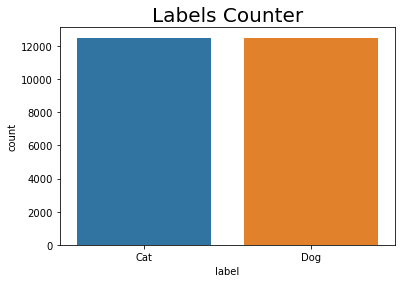

In [225]:
plt.subplots(figsize = (6,4))
plt.title("Labels Counter", size=20)
fig = sns.countplot(num_to_name(target))

## Data Processing